# Modelagem

In [186]:
import os
import shutil
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from warnings import filterwarnings
from typing import List, Set, Tuple, Optional
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [187]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [188]:
def overdisp_plot(model, model_type_name, title = None):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Contínuos)")
  plt.ylabel("Resíduos de Pearson Padronizados")

  if not title:
    plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  else:
    plt.title(title.format(model_type_name))

  plt.grid(True, linestyle='--', alpha=0.7)

In [189]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df = df.filter(pl.col('amount') >= pl.lit(0))
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""
7475335,2010-01-01 00:14:00,1684,2140,26.46,"""Online Transaction""",39021,"""ONLINE""",null,null,"""4784""",null,"""Tolls and Bridge Fees""","""No""",56,65,1963,11,"""Male""","""27019 Madison Lane""",36.34,-83.28,13668.0,27861.0,108313.0,782,5,"""Mastercard""","""Debit (Prepaid)""",5955075527372953,"""05/2021""",513,"""YES""",1,46.0,"""03/2007""",2012,"""No"""


In [190]:
df.shape

(8472184, 38)

In [191]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')

In [192]:
df = df.with_columns(
    pl.col('date').dt.truncate('15m').alias('date_window')
)

In [193]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

In [217]:
class WindowDataBuilder:
    """
    Builder class for creating time-windowed features for fraud detection.

    This class transforms raw transaction data into aggregated features
    organized by time windows, specifically designed for fraud detection models.
    """

    # Class constants for better maintainability
    CATEGORICAL_COLUMNS = ['city', 'country', 'description']
    DEFAULT_CORRELATION_THRESHOLD = 0.75
    DEFAULT_N_CLUSTERS = 3

    # Scale factors for feature normalization
    SCALE_FACTORS = {
        'amount': 1_000,
        'per_capita_income': 1_000,
        'total_debt': 10_000,
        'credit_score': 100,
        'credit_limit': 10_000,
    }

    def __init__(self, df: pl.DataFrame):
        """
        Initialize the WindowDataBuilder.

        Args:
            df (pl.DataFrame): Input DataFrame containing transaction data

        Raises:
            ValueError: If required columns are missing from the DataFrame
        """
        self._validate_input_data(df)
        self.df = df
        self._scaler = MinMaxScaler()

    def _validate_input_data(self, df: pl.DataFrame) -> None:
        """Validate that required columns exist in the input DataFrame."""
        required_columns = {'date', 'target', 'client_id', 'merchant_id', 'amount'}
        missing_columns = required_columns - set(df.columns)
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

    def create_cluster_target_fields(
        self,
        df: pl.DataFrame,
        group_column_name: str,
        target_column_name: str,
        n_clusters: int = DEFAULT_N_CLUSTERS,
        drop_first: bool = False
    ) -> pl.DataFrame:
        """
        Create clustered categorical features based on target variable patterns.

        Args:
            df: Input DataFrame
            group_column_name: Column to group by
            target_column_name: Target variable column
            n_clusters: Number of clusters for KMeans
            drop_first: Whether to drop first dummy variable

        Returns:
            DataFrame with clustered dummy variables
        """
        try:
            # Define column names for better readability
            percent_target_col = f'percent_{target_column_name}'
            percent_no_target_col = f'percent_no_{target_column_name}'
            ab_col = 'ab'
            target_cluster_col = f'{target_column_name}_{group_column_name}'

            # Calculate target percentages by group
            df_cat_group = (
                df.group_by(group_column_name)
                .agg([
                    ((pl.col(target_column_name).sum() / pl.count()) * 100).alias(percent_target_col),
                    (((pl.count() - pl.col(target_column_name).sum()) / pl.count()) * 100).alias(percent_no_target_col)
                ])
                .with_columns([
                    # Calculate A/B ratio with proper handling of edge cases
                    pl.when(pl.col(percent_no_target_col) == 0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(percent_target_col) / pl.col(percent_no_target_col))
                    .alias(ab_col)
                ])
                .with_columns([
                    # Cap the A/B ratio at 100 for stability
                    pl.when(pl.col(ab_col) > 100.0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(ab_col))
                    .alias(ab_col)
                ])
            )

            # Apply clustering
            ab_values = df_cat_group.select(ab_col).to_pandas()
            scaled_values = self._scaler.fit_transform(ab_values)

            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(scaled_values)

            # Add cluster labels and create dummy variables
            df_cat_group = df_cat_group.with_columns(
                pl.lit(cluster_labels).alias(target_cluster_col)
            )

            return (
                df_cat_group
                .select([group_column_name, target_cluster_col])
                .to_dummies(columns=[target_cluster_col], drop_first=drop_first)
            )

        except Exception as e:
            raise RuntimeError(f"Error in create_cluster_target_fields: {str(e)}")

    def _generate_column_statistics(self, column_name: str, divide_by: float = 1.0) -> List[pl.Expr]:
        """
        Generate statistical aggregations for a column.

        Args:
            column_name: Name of the column to generate statistics for
            divide_by: Scaling factor for normalization

        Returns:
            List of Polars expressions for statistical aggregations
        """
        return [
            (pl.col(column_name).min() / divide_by).alias(f'min_{column_name}'),
            (pl.col(column_name).mean() / divide_by).alias(f'mean_{column_name}'),
            (pl.col(column_name).max() / divide_by).alias(f'max_{column_name}'),
            (pl.col(column_name).std() / divide_by).alias(f'std_{column_name}'),
        ]

    def _create_base_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """
        Create base numerical features aggregated by time window.

        Args:
            df: Input DataFrame with date_window column

        Returns:
            DataFrame with aggregated numerical features
        """
        try:
            # Build aggregation expressions dynamically
            agg_expressions = [
                pl.col("target").sum().alias("frauds"),
                pl.col("target").count().alias("transactions"),
                pl.col("client_id").n_unique().alias("unique_clients"),
                pl.col("merchant_id").n_unique().alias("unique_merchants"),
                pl.col("amount").sum().alias("total_amount"),
            ]

            # Add statistical features for numerical columns
            for column, scale_factor in self.SCALE_FACTORS.items():
                if column in df.columns:
                    agg_expressions.extend(
                        self._generate_column_statistics(column, scale_factor)
                    )

            # Add statistics for columns without scaling
            for column in ['current_age', 'num_credit_cards']:
                if column in df.columns:
                    agg_expressions.extend(
                        self._generate_column_statistics(column, 1.0)
                    )

            # Perform aggregation
            df_features = (
                df.group_by("date_window")
                .agg(agg_expressions)
                .with_columns([
                    (pl.col("transactions") / pl.col("unique_clients")).alias("transaction_per_client"),
                    (pl.col("transactions") / pl.col("unique_merchants")).alias("transaction_per_merchant"),
                ])
                .drop([
                    "transactions", "total_amount", "unique_clients", "unique_merchants"
                ] + [f"min_{col}" for col in ["amount"] if col in df.columns]
                  + [f"max_{col}" for col in ["amount"] if col in df.columns])
                .drop_nulls()
            )

            return df_features

        except Exception as e:
            raise RuntimeError(f"Error creating base features: {str(e)}")

    def _process_categorical_features(self, df: pl.DataFrame, df_base: pl.DataFrame) -> pl.DataFrame:
        """
        Process categorical features and merge with base features.

        Args:
            df: Original DataFrame with categorical columns
            df_base: Base features DataFrame

        Returns:
            DataFrame with categorical and numerical features combined
        """
        result_df = df_base

        for column in self.CATEGORICAL_COLUMNS:
            if column not in df.columns:
                continue

            try:
                # Create cluster features for categorical column
                df_target_cat = self.create_cluster_target_fields(
                    df, column, 'target', drop_first=False
                )

                # Aggregate categorical features by time window
                df_with_cat = (
                    df.select(['date_window', column])
                    .join(df_target_cat, on=column, how='left')
                    .drop(column)
                    .group_by('date_window')
                    .sum()
                )

                # Calculate proportions if there are categorical features
                if len(df_with_cat.columns) > 1:
                    df_with_cat = df_with_cat.with_columns(
                        pl.sum_horizontal([
                            pl.col(col) for col in df_with_cat.columns[1:]
                        ]).alias('total')
                    )

                    # Calculate proportions for each categorical feature
                    proportion_expressions = [
                        (pl.col(col) / pl.col('total')).alias(col)
                        for col in df_with_cat.columns[1:-1]  # Exclude date_window and total
                    ]

                    if proportion_expressions:
                        df_with_cat = (
                            df_with_cat.with_columns(proportion_expressions)
                            .drop('total')
                        )

                    # Merge with result DataFrame
                    result_df = result_df.join(df_with_cat, on='date_window', how='left')

            except Exception as e:
                print(f"Warning: Error processing categorical column '{column}': {str(e)}")
                continue

        return result_df

    def _remove_highly_correlated_features(
        self,
        df: pd.DataFrame,
        threshold: float = DEFAULT_CORRELATION_THRESHOLD
    ) -> List[str]:
        """
        Identify features with high correlation for removal.

        Args:
            df: Input DataFrame
            threshold: Correlation threshold for removal

        Returns:
            List of column names to remove
        """
        try:
            if df.empty or len(df.columns) <= 1:
                return []

            # Calculate correlation matrix more efficiently
            corr_matrix = df.corr()

            # Create mask for upper triangle
            upper_triangle = np.triu(np.abs(corr_matrix), k=1)

            # Find highly correlated pairs
            high_corr_pairs = np.where(upper_triangle > threshold)
            columns_to_remove: Set[str] = set()

            # Process correlated pairs
            for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]

                # Skip if either column already marked for removal
                if col_i in columns_to_remove or col_j in columns_to_remove:
                    continue

                # Remove column with lower variance
                var_i = df[col_i].var()
                var_j = df[col_j].var()

                if pd.isna(var_i) or pd.isna(var_j):
                    continue

                if var_i < var_j:
                    columns_to_remove.add(col_i)
                else:
                    columns_to_remove.add(col_j)

            return list(columns_to_remove)

        except Exception as e:
            print(f"Warning: Error in correlation analysis: {str(e)}")
            return []

    def build(self, window: str) -> pd.DataFrame:
        """
        Build the complete feature dataset for the specified time window.

        Args:
            window: Time window specification (e.g., '1d', '1w', '1mo')

        Returns:
            pandas DataFrame with engineered features ready for modeling

        Raises:
            ValueError: If window specification is invalid
            RuntimeError: If feature engineering fails
        """
        try:
            if not isinstance(window, str) or not window.strip():
                raise ValueError("Window must be a non-empty string")

            # Create time windows
            df_windowed = self.df.with_columns(
                pl.col('date').dt.truncate(window).alias('date_window')
            )

            # Create base numerical features
            df_base = self._create_base_features(df_windowed)

            # Process categorical features
            df_with_categories = self._process_categorical_features(df_windowed, df_base)

            # Convert to pandas for correlation analysis
            df_pandas = df_with_categories.to_pandas()

            # Remove highly correlated features
            columns_to_remove = self._remove_highly_correlated_features(
                df_pandas.drop(columns=['date_window'], errors='ignore')
            )

            if columns_to_remove:
                df_pandas = df_pandas.drop(columns=columns_to_remove, errors='ignore')
                print(f"Removed {len(columns_to_remove)} highly correlated features")

            return df_pandas

        except Exception as e:
            raise RuntimeError(f"Error building features: {str(e)}")

    def get_feature_info(self) -> dict:
        """
        Get information about the feature engineering process.

        Returns:
            Dictionary with feature engineering configuration
        """
        return {
            'categorical_columns': self.CATEGORICAL_COLUMNS,
            'correlation_threshold': self.DEFAULT_CORRELATION_THRESHOLD,
            'n_clusters': self.DEFAULT_N_CLUSTERS,
            'scale_factors': self.SCALE_FACTORS,
        }

In [218]:
window_data_builder = WindowDataBuilder(df)
df_train = window_data_builder.build('15m')
df_train.head()

,date_window,frauds,std_amount,min_current_age,median_current_age,max_current_age,std_current_age,min_per_capita_income,median_per_capita_income,max_per_capita_income,...,std_num_credit_cards,min_credit_limit,median_credit_limit,max_credit_limit,transaction_per_client,transaction_per_merchant,target_city_0,target_city_1,target_description_0,target_description_2
0,2012-12-03 12:15:00,0,0.033402,36.0,59.333333,92.0,13.783293,8.155,22.482394,76.725,...,2.030077,0.0049,1.423370,3.3980,1.000000,1.100000,1.0,0.0,1.0,0.0
1,2015-05-19 14:30:00,0,0.045692,34.0,56.782609,90.0,14.257806,0.000,24.371370,79.100,...,1.502976,0.0085,1.555298,5.4517,1.045455,1.314286,1.0,0.0,1.0,0.0
2,2019-01-16 09:45:00,0,0.078407,29.0,50.275862,86.0,16.236855,12.557,26.111310,94.302,...,1.688851,0.0026,1.859076,6.2760,1.000000,1.208333,1.0,0.0,1.0,0.0
3,2011-08-28 21:15:00,0,0.093688,31.0,54.285714,90.0,15.123828,0.000,26.429179,95.039,...,1.476446,0.0000,2.058375,13.7669,1.000000,1.000000,1.0,0.0,1.0,0.0
4,2015-09-20 01:15:00,0,0.040506,37.0,52.250000,62.0,9.392246,11.073,22.078125,53.676,...,1.125992,0.0090,1.230475,3.0024,1.000000,1.000000,1.0,0.0,1.0,0.0


In [219]:
df_train.describe()

,date_window,frauds,std_amount,min_current_age,median_current_age,max_current_age,std_current_age,min_per_capita_income,median_per_capita_income,max_per_capita_income,...,std_num_credit_cards,min_credit_limit,median_credit_limit,max_credit_limit,transaction_per_client,transaction_per_merchant,target_city_0,target_city_1,target_description_0,target_description_2
count,341887,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000,...,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000,341887.000000
mean,2014-12-02 19:34:21.133649664,0.037550,0.062013,31.752883,53.874373,84.231770,15.233035,11.526099,23.785456,54.696711,...,1.535632,0.151806,1.545539,4.510565,1.028498,1.150621,0.999965,0.000003,0.999948,0.000018
min,2010-01-01 00:00:00,0.000000,0.000000,23.000000,23.500000,24.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001650,0.003300,1.000000,1.000000,0.666667,0.000000,0.666667,0.000000
25%,2012-06-18 20:07:30,0.000000,0.037573,28.000000,51.480000,80.000000,13.667076,11.061000,22.007689,36.852000,...,1.372340,0.004200,1.363390,3.090300,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,2014-12-03 07:30:00,0.000000,0.048782,31.000000,53.891304,86.000000,15.465071,12.427000,23.582222,49.629000,...,1.539247,0.006300,1.530250,4.001900,1.000000,1.136364,1.000000,0.000000,1.000000,0.000000
75%,2017-05-18 13:22:30,0.000000,0.069939,34.000000,56.250000,92.000000,17.074777,13.963000,25.293000,58.517000,...,1.707825,0.079300,1.708765,5.303600,1.047619,1.242424,1.000000,0.000000,1.000000,0.000000
max,2019-10-31 23:45:00,5.000000,2.347053,88.000000,93.000000,101.000000,51.618795,94.302000,94.670500,163.145000,...,5.656854,4.930000,6.961150,14.139100,3.000000,3.000000,1.000000,0.250000,1.000000,0.200000
std,NaN,0.225311,0.046457,5.950106,4.514638,11.379189,3.434405,5.004151,3.120824,26.930263,...,0.352422,0.329734,0.330111,2.295082,0.043762,0.136785,0.001804,0.000561,0.001965,0.000871


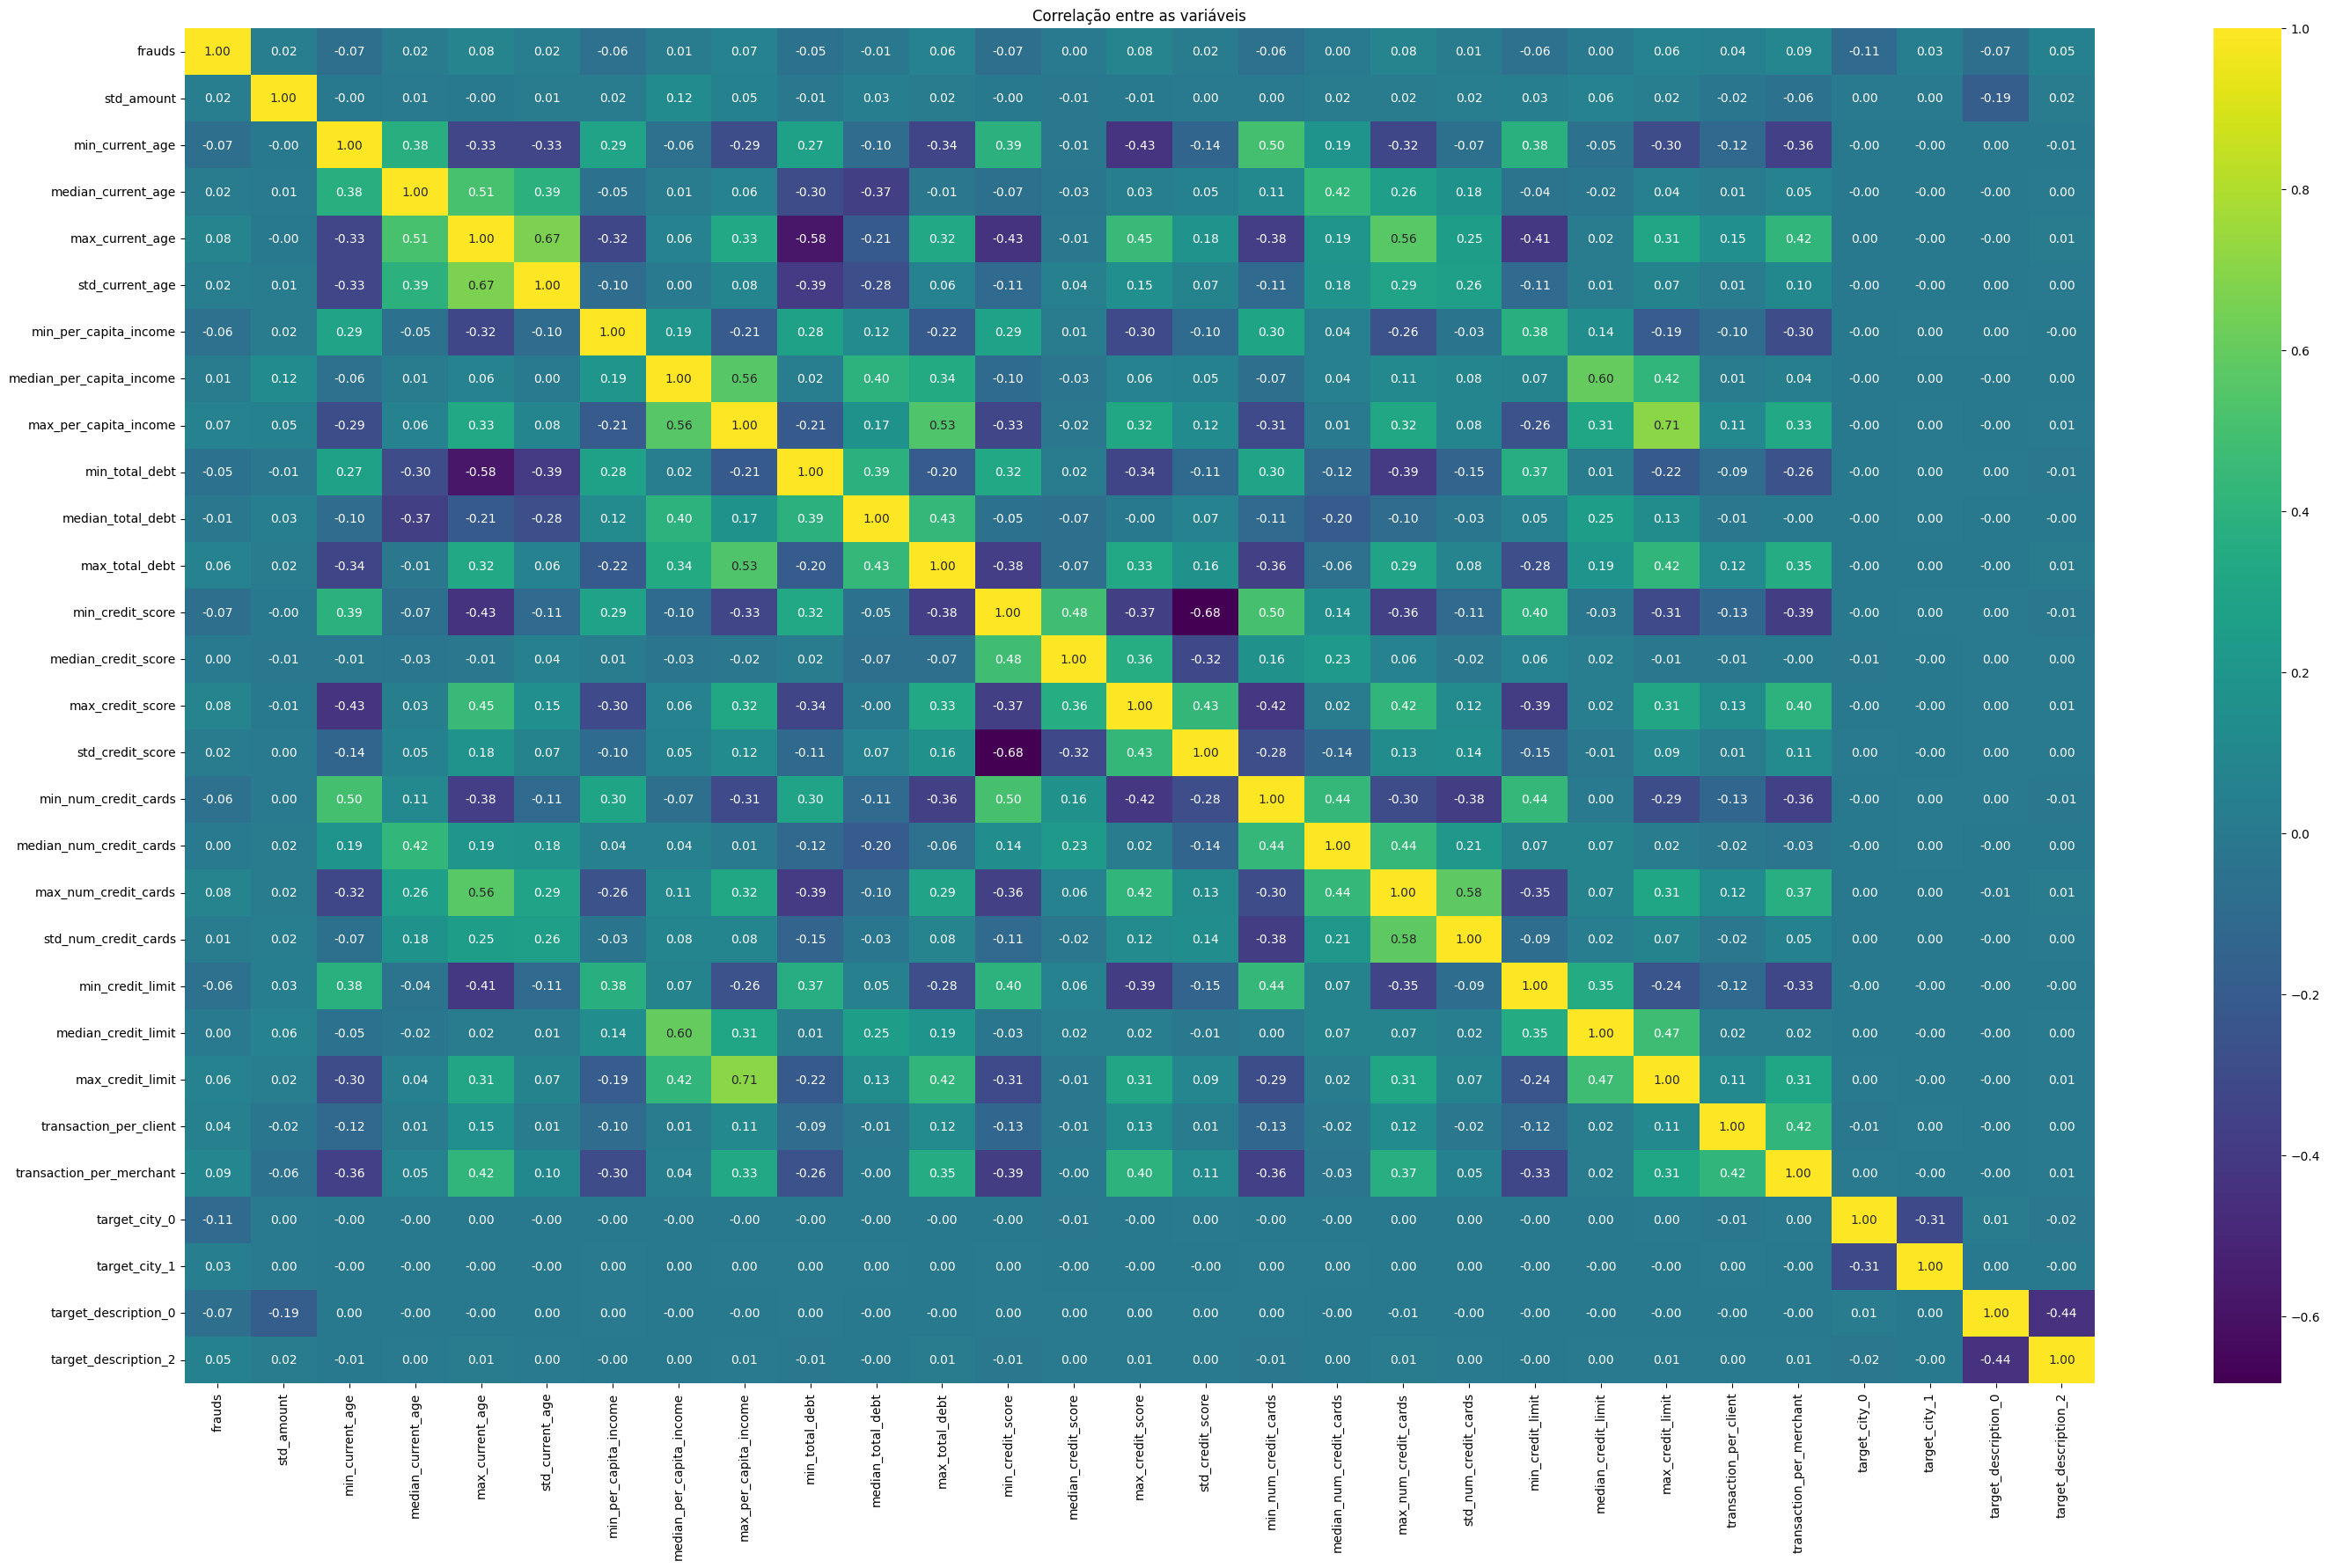

In [220]:
corr = df_train.drop(columns=['date_window']).corr()

plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [221]:
y = df_train['frauds']
X = df_train.drop(columns=['frauds', 'date_window'])

In [222]:
X1 = X.copy()
X1 = sm.add_constant(X)

In [ ]:
model = sm.ZeroInflatedNegativeBinomialP(y, X1, X1).fit(disp=False, method='bfgs', cov_type='HC0')
model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1074: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1567: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1568: RuntimeWarning: overflow encountered in multiply
  return -np.dot(L*X.T, X)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1568: RuntimeWarning: invalid value encountered in multiply
  return -np.dot(L*X.T, X)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:1478: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)


In [ ]:
overdisp_plot(model, 'BNEG')
